In [81]:
from cassandra.cluster import Cluster
import spacy
import pandas as pd

nlp = spacy.load('en_core_web_lg')
cluster = Cluster(['127.0.0.1'])
session = cluster.connect('sharelock')

In [82]:
def get_sentence_score(doc):
    # number of entitites * number of sentences
    num_sents = len(list(doc.sents))
    num_ents = len(list(doc.ents))
    return num_sents * num_ents
    

In [83]:
topic_list_query = "SELECT * from sharelock.topic_list"
topic_rows = session.execute(topic_list_query)
topic_row_list = list(topic_rows)
topic_frames = pd.DataFrame(topic_row_list)  

categories = set()
for idx, row in topic_frames.iterrows():
      categories.add(row['category'])

CATEGORY_LIST = list(categories)        


In [84]:
import datetime
def get_category_spam_classifier(category):    
    return 1


In [85]:
def get_category_relevance_classifier(topic):
    return 1

In [86]:
import datetime
def category_data_frame(category):
    # crunch numbers every 10 minutes with data fron last 30 minutes
    lastHourDateTime = datetime.datetime.now() - datetime.timedelta(days = 1)
    date_str = lastHourDateTime.strftime("%Y-%m-%d %H:%M:%S")
    sql_str = "SELECT * FROM sharelock.labelled_tweets WHERE category='"+category+"' allow filtering;"
    df_filtered = []
    rows = session.execute(sql_str)
    row_list = list(rows)
    if len(row_list) > 0:
        result = pd.DataFrame(row_list)   
        df_filtered = result.query('is_graded')
    df_filtered.set_index('tweet_id')
    df_filtered = df_filtered.drop_duplicates(subset='tweet_id', keep='last')
    return df_filtered



In [87]:
def get_sentence_score(tweet_doc):
    # number of entitites * number of sentences
    num_sents = len(list(tweet_doc.sents))
    num_ents = len(list(tweet_doc.ents))
    return num_sents * num_ents
        

In [88]:
# number of hash-tags or mentions
def get_tag_score(doc):
    tag_score = 0
    for token in doc:
        if "#" in token.text or "@" in token.text:
            tag_score = tag_score + 1 
    return tag_score  

In [89]:
upper_caps_stops = ['I']
import constants

spam_word_stops = constants.SPAM_WORDS

def get_structure_score(doc):
    token_penalty = 0
    for token in doc:
        token_text = token.text
        prev_token_caps = False
        if token_text.isupper():
            if prev_token_caps:
                token_penalty = token_penalty + 10
            prev_token_caps = True
        else:
            prev_token_caps = False
        if token_text in upper_caps_stops:
            token_penalty = token_penalty + 10
        if token_text.lower() in spam_word_stops:
            token_penalty = token_penalty + 10 
    return token_penalty    

In [90]:
import numpy as np
from langdetect import detect

# get corpus of news text on topic
def get_topic_web_corpus(category):
    sql_str = "SELECT * from sharelock.topic_link_data where link_category='"+category+"' allow filtering;"
    corpus_data = session.execute(sql_str)
    topic_corpus = pd.DataFrame(list(corpus_data))
    topic_corpus['body_doc'] = topic_corpus['link_text'].apply(nlp)
    topic_corpus['head_doc'] = topic_corpus['link_title'].apply(nlp)
    return topic_corpus

web_corpus_list = {}

doc_title_list = []
doc_body_list = []

for category in CATEGORY_LIST:
    web_corpus = get_topic_web_corpus(category)
    web_corpus_list[category] = web_corpus

    
def get_body_relevance_score(sentence_doc, frame_category):
    category_text_corpus = web_corpus_list[frame_category]
    body_relevance_score = []
    counter = 0
    for corpus_body in category_text_corpus['body_doc']:
        body_sents = corpus_body.sents
        counter = counter + len(list(body_sents)) 
        for corpus_sentence in body_sents:
            body_relevance_score.append(corpus_sentence.as_doc().similarity(sentence_doc))         
    return body_relevance_score    


def get_head_relevance_score(sentence_doc, frame_category):
    category_text_corpus = web_corpus_list[frame_category]

    head_relevance_score = []
    counter = 0
    for corpus_head in category_text_corpus['head_doc']:
        head_sents = corpus_head.sents
        counter = counter + len(list(head_sents))   
        for corpus_sentence in head_sents:
            head_relevance_score.append(corpus_sentence.as_doc().similarity(sentence_doc))      
    return head_relevance_score    
    
    

In [91]:
import math
def get_raw_score(frame):
    user_score = 1
    if frame['user_score'] > 1:
        user_score = math.log(frame['user_score'])
    base_score = frame['likes'] + frame['retweets'] * 2
    if base_score < 1:
        base_score = 1
    return base_score * user_score 

crypto


/home/ubuntu/anaconda3/envs/ml_conda/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


software
drone
gaming


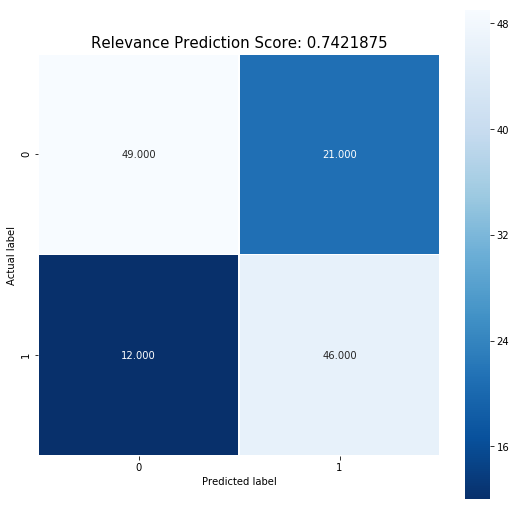

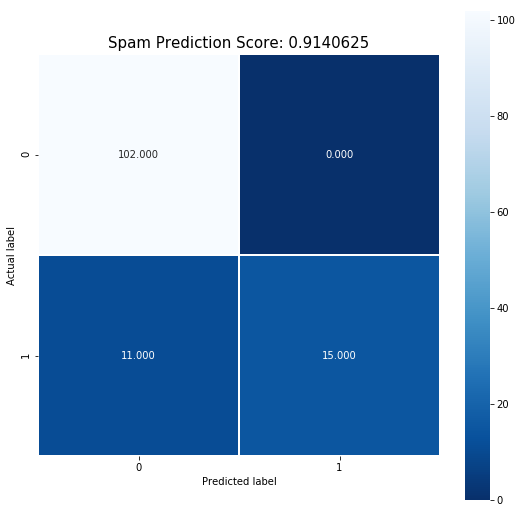

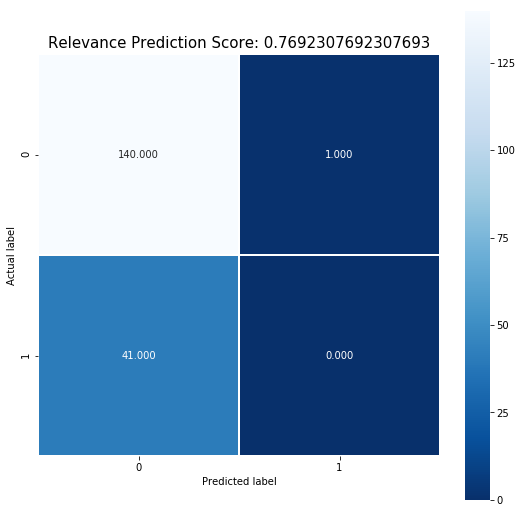

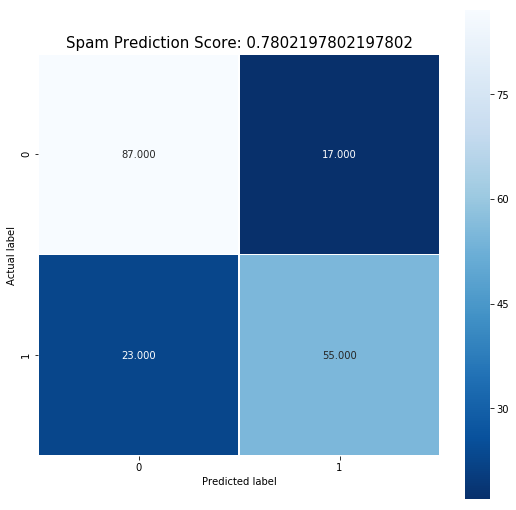

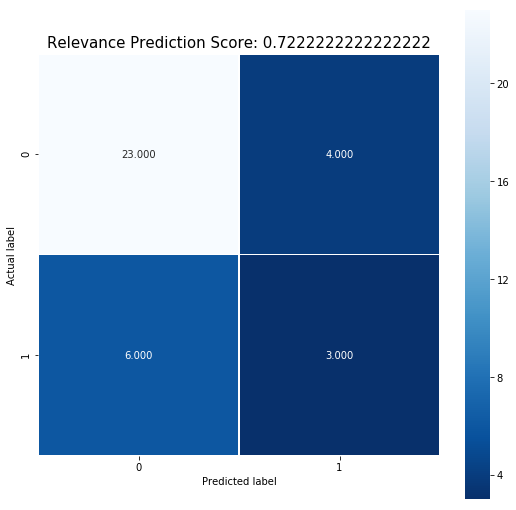

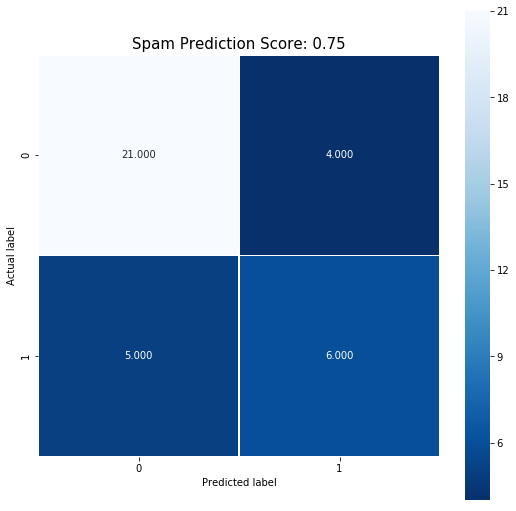

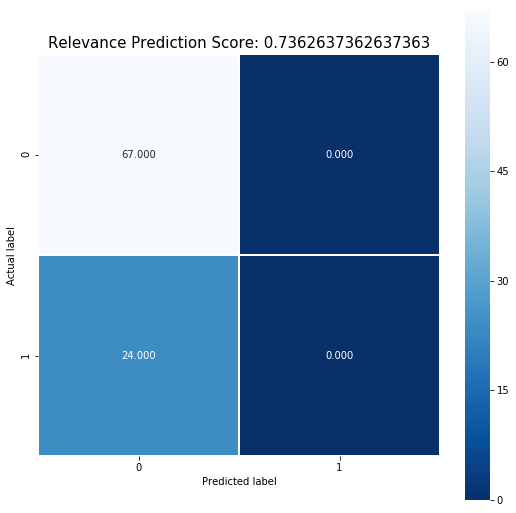

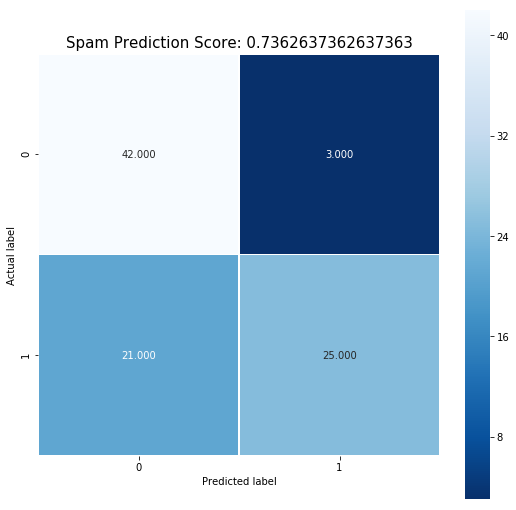

In [92]:
from sklearn_pandas import DataFrameMapper, cross_val_score
# update table save features
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.externals import joblib
    
for category in CATEGORY_LIST:
    category_frame = category_data_frame(category)
    tf_vect =  TfidfVectorizer({"analyzer": "word", "ngram_range": (1, 3), "stop_words": "english", "max_df": 1.0, "min_df": 4})
    if (len(category_frame)) > 0:
        category_frame['text_tokens'] = category_frame['tweet_text'].apply(nlp)
        category_frame['sentence_score'] = category_frame['text_tokens'].apply(get_sentence_score)
        category_frame['tag_score'] = category_frame['text_tokens'].apply(get_tag_score)
        category_frame['structure_score'] = category_frame['text_tokens'].apply(get_structure_score)
        category_frame['raw_score'] = category_frame.apply(get_raw_score, axis=1)
        category_frame['body_relevance_score'] = category_frame['text_tokens'].apply(get_body_relevance_score, args = (category,))
        category_frame['head_relevance_score'] = category_frame['text_tokens'].apply(get_head_relevance_score, args = (category,))
        print(category)
        mapped_features = DataFrameMapper([
            ('tweet_text', tf_vect),
            (['sentence_score'], MinMaxScaler(feature_range=(0, 1))),
            (['tag_score'], MinMaxScaler(feature_range=(0, 1))),
            (['structure_score'], MinMaxScaler(feature_range=(0, 1))),
            (['raw_score'], MinMaxScaler(feature_range=(0, 1))),
            (['user_score'], MinMaxScaler(feature_range=(0, 1)))
        ])

        feature_vector = mapped_features.fit_transform(category_frame)        
        head_relevance_matrix = category_frame['body_relevance_score'].values
        body_relevance_matrix = category_frame['head_relevance_score'].values
        final_features = []

        for idx, f in enumerate(feature_vector):
            final_features.append(list(feature_vector[idx]) + list(head_relevance_matrix[idx]) + list(body_relevance_matrix[idx]))
                                  
        result_frame = category_frame['is_relevant'].astype(int)   
        y_frame = result_frame.astype('int')
        X_train, X_test, y_train, y_test = train_test_split(final_features, y_frame, test_size=0.33, random_state=42)

        relevance_log_reg = LogisticRegression()

        try:
            relevance_log_reg.fit(X_train, y_train)
            predictions = relevance_log_reg.predict(X_test)
            pr = metrics.mean_absolute_error(y_test, predictions)
            from sklearn.metrics import confusion_matrix
            confusion_matrix = confusion_matrix(y_test, predictions)
            cm = metrics.confusion_matrix(y_test, predictions)
            score = relevance_log_reg.score(X_test, y_test)

            plt.figure(figsize=(9,9))
            sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
            plt.ylabel('Actual label');
            plt.xlabel('Predicted label');
            all_sample_title = 'Relevance Prediction Score: {0}'.format(score)
            plt.title(all_sample_title, size = 15);
            
        except Exception as e:
            print(e)
            
        result_frame = category_frame['is_spam'].astype(int)    
        y_frame = result_frame.astype('int')
        X_train, X_test, y_train, y_test = train_test_split(final_features, y_frame, test_size=0.33, random_state=42)

        spam_log_reg = LogisticRegression()
        try:
            spam_log_reg.fit(X_train, y_train)
            predictions = spam_log_reg.predict(X_test)
            pr = metrics.mean_absolute_error(y_test, predictions)
            cm = metrics.confusion_matrix(y_test, predictions)
            score = spam_log_reg.score(X_test, y_test)
            
            plt.figure(figsize=(9,9))
            sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
            plt.ylabel('Actual label');
            plt.xlabel('Predicted label');
            all_sample_title = 'Spam Prediction Score: {0}'.format(score)
            plt.title(all_sample_title, size = 15);

        except Exception as e:
            print(e)     
                         
        joblib.dump(relevance_log_reg, '%s-relevance-classifier.pkl' % category) 
        joblib.dump(spam_log_reg, '%s-spam-classifier.pkl' % category) 

        joblib.dump(tf_vect, '%s-tf-vect.pkl' % category)
        joblib.dump(mapped_features, '%s-mapper.pkl' % category)
        